In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mass import MassSpectrum
from mass import VanKrevelen

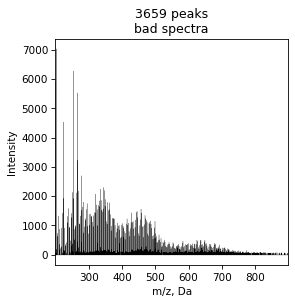

In [14]:
spec = MassSpectrum().load(filename="data/bad_masslist.txt",
                            mapper={'m/z':'mass', 'Intensity':'I'},
                            take_columns=['mass','I'],
                            sep='\t',
                            treshold=50
                            )
fig, ax = plt.subplots(figsize=(4, 4), dpi=75)
spec.draw(ax=ax, name='bad spectra')

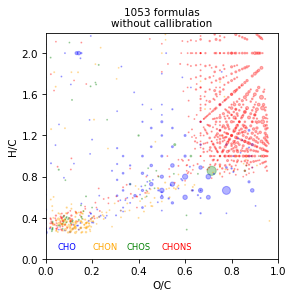

In [15]:
spec = spec.assign()
vk = VanKrevelen(spec.table, name='without callibration').draw_scatter()

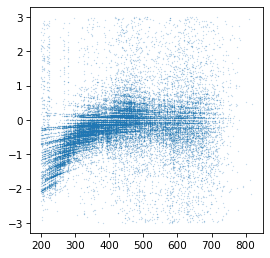

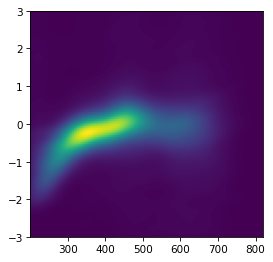

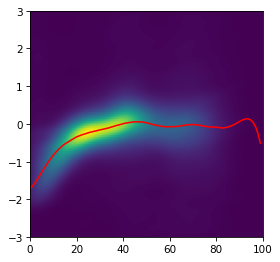

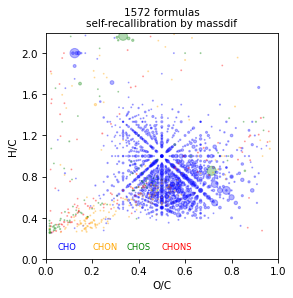

In [16]:
spec = MassSpectrum().load(filename="data/bad_masslist.txt",
                            mapper={'m/z':'mass', 'Intensity':'I'},
                            take_columns=['mass','I'],
                            sep='\t',
                            treshold=50
                            )

spec = spec.recallibrate_by_massdiff()
spec = spec.assign()
vk = VanKrevelen(spec.table, name='self-recallibration by massdif').draw_scatter()

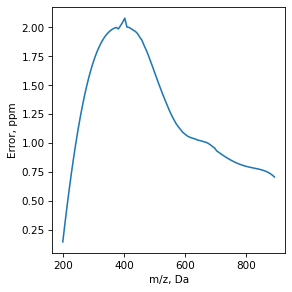

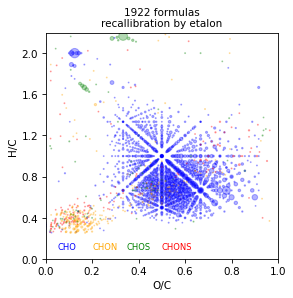

In [17]:
spec = MassSpectrum().load(filename="data/bad_masslist.txt",
                            mapper={'m/z':'mass', 'Intensity':'I'},
                            take_columns=['mass','I'],
                            sep='\t',
                            treshold=50
                            )

etalon = MassSpectrum().load(filename="data/etalon.csv",
                            mapper={'m/z':'mass', 'I':'I'},
                            take_columns=['mass','I'],
                            sep=',',
                            )

spec = spec.recallibrate_by_etalon(etalon)
spec = spec.assign()
vk = VanKrevelen(spec.table, name='recallibration by etalon').draw_scatter()

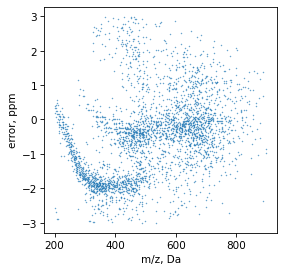

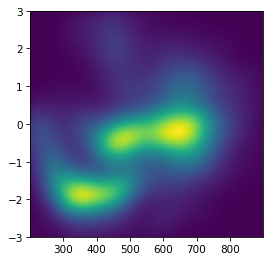

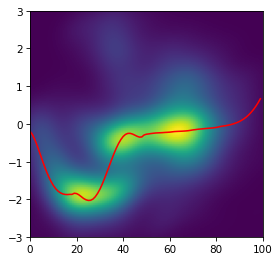

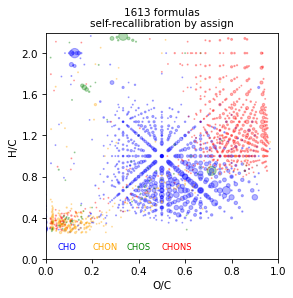

In [18]:
spec = MassSpectrum().load(filename="data/bad_masslist.txt",
                            mapper={'m/z':'mass', 'Intensity':'I'},
                            take_columns=['mass','I'],
                            sep='\t',
                            treshold=50
                            )

spec = spec.assign(rel_error=3)
spec = spec.recallibrate_by_assign()
spec = spec.assign()
vk = VanKrevelen(spec.table, name='self-recallibration by assign').draw_scatter()

#### Use callibrate from one spectr for another

take err dataframe right after recallibration

,i,ppm
0,0,-0.000000
1,1,0.084620
2,2,0.214100
3,3,0.372245
4,4,0.545525
...,...,...
95,95,-0.505142
96,96,-0.578766
97,97,-0.663084
98,98,-0.758984


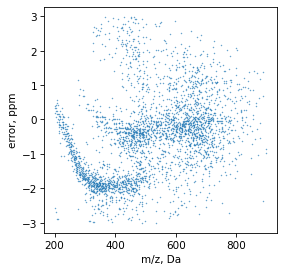

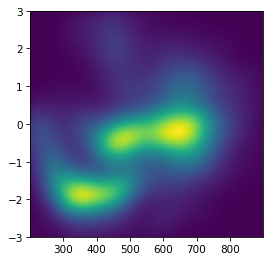

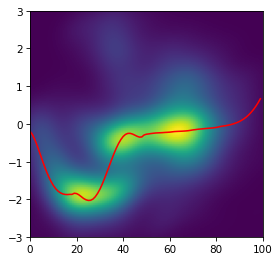

In [19]:
spec = MassSpectrum().load(filename="data/bad_masslist.txt",
                            mapper={'m/z':'mass', 'Intensity':'I'},
                            take_columns=['mass','I'],
                            sep='\t',
                            treshold=50
                            )

spec = spec.assign(rel_error=3)
spec = spec.recallibrate_by_assign()
err = spec.err
err

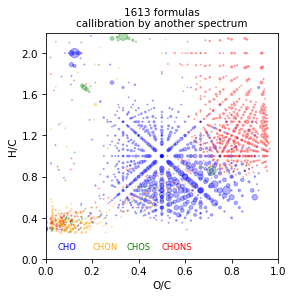

In [20]:
another_spec = MassSpectrum().load(filename="data/bad_masslist.txt",
                                mapper={'m/z':'mass', 'Intensity':'I'},
                                take_columns=['mass','I'],
                                sep='\t',
                                treshold=50
                                )

another_spec = another_spec.recallibrate(another_spec.table, err)
spec = spec.assign()
vk = VanKrevelen(spec.table, name='callibration by another spectrum').draw_scatter()